## Compare Graph Signatures

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from pygsp import graphs, filters, plotting, reduction
import os.path
from global_graph import GlobalGraph
from wavelet_evaluator import WaveletEvaluator


%load_ext autoreload
%autoreload 2
%matplotlib inline

plotting.BACKEND = 'matplotlib'
plt.rcParams['figure.figsize'] = (10, 5)

print(f'\n\nLoading....')

dataroot = '/mnt/data/datasets/fgsp/'
datasets = ['test/']

n_datasets = len(datasets)
opt_signals = []
est_signals = []
opt_trajectory = []
est_trajectory = []
est_raw_trajectory = []
opt_graph_coords = []
opt_graph_adj = []
for ds in datasets:
    ds_path = dataroot + ds
    print(f'Loading data from {ds_path}')
    opt_signal_path = ds_path + 'opt_signal.npy'
    opt_traj_path = ds_path + 'opt_trajectory.npy'
    est_signal_path = ds_path + 'est_signal.npy'
    est_traj_path = ds_path + 'est_trajectory.npy'  
    est_raw_traj_path = ds_path + 'est_raw_trajectory.npy'  
    opt_graph_coords_path = ds_path + 'opt_graph_coords.npy'
    opt_graph_adj_path = ds_path + 'opt_graph_adj.npy'
 
    if os.path.isfile(opt_signal_path) and os.path.isfile(est_signal_path):
        opt_signals.append(np.load(opt_signal_path))
        est_signals.append(np.load(est_signal_path))
    else:
        print(f'Signal files are not available:')
        print(f'Opt file: {opt_signal_path}')
        print(f'Est file: {est_signal_path}')
        
    if os.path.isfile(opt_traj_path) and os.path.isfile(est_traj_path) and os.path.isfile(est_raw_traj_path):
        opt_trajectory.append(np.load(opt_traj_path))
        est_trajectory.append(np.load(est_traj_path))
        est_raw_trajectory.append(np.load(est_raw_traj_path))
    else:
        print(f'Trajectory files are not available.')
        print(f'Opt file: {opt_traj_path}')
        print(f'Est file: {est_traj_path}')
        print(f'Est raw file: {est_raw_traj_path}')
    
    if os.path.isfile(opt_graph_coords_path) and os.path.isfile(opt_graph_adj_path):
        opt_graph_coords.append(np.load(opt_graph_coords_path))
        opt_graph_adj.append(np.load(opt_graph_adj_path))
    else:
        print(f'Graph files are not available.')
        print(f'Coords file: {opt_graph_coords_path}')
        print(f'Adj file: {opt_graph_adj_path}')
    
print(f'=======================================')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading....
Loading data from /mnt/data/datasets/fgsp/test/


Built 1 global and robot graphs.


(<Figure size 720x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f45c3ecc240>)

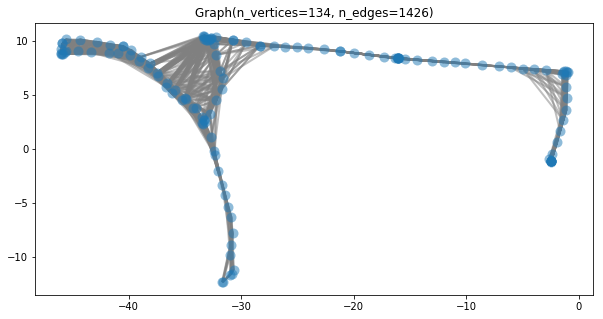

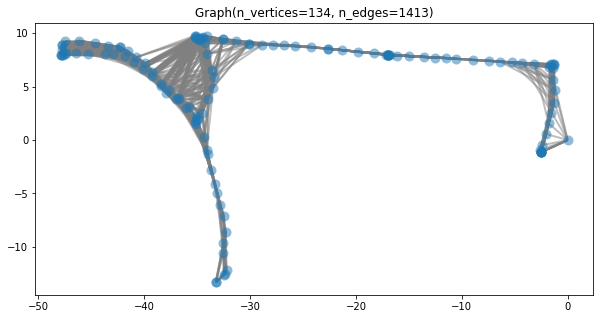

In [11]:
global_graph_per_dataset = []
robot_graph_per_dataset = []

for i in range(0, n_datasets):
    global_graph = GlobalGraph()
    global_graph.build_graph_from_coords_and_adj(opt_graph_coords[i], opt_graph_adj[i])    
    global_graph_per_dataset.append(global_graph)
    
    robot_graph = GlobalGraph()        
    robot_graph.build_from_poses(est_trajectory[i][:,1:4])    
    robot_graph_per_dataset.append(robot_graph)

n_graphs = len(global_graph_per_dataset)
assert n_graphs  == len(robot_graph_per_dataset)
print(f'Built {n_graphs} global and robot graphs.')

global_graph_per_dataset[0].G.plot()
robot_graph_per_dataset[0].G.plot()

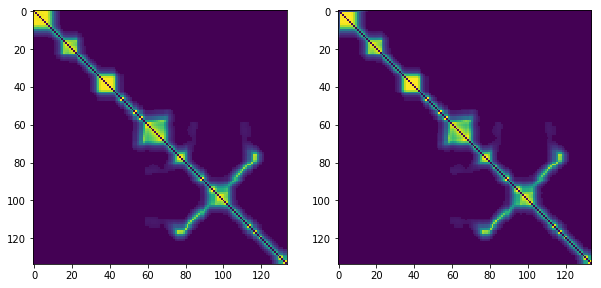

In [12]:
plt.subplot(1, 2, 1)
global_adj_plot = plt.imshow(global_graph_per_dataset[0].G.W.toarray())
plt.subplot(1, 2, 2)
robot_adj_plot = plt.imshow(robot_graph_per_dataset[0].G.W.toarray())

In [17]:
i = 0
global_graph_eval = WaveletEvaluator()
robot_graph_eval = WaveletEvaluator()
global_graph_eval.compute_wavelets(global_graph_per_dataset[i].G)
robot_graph_eval.compute_wavelets(robot_graph_per_dataset[i].G)

x_opt = opt_signals[i]
x_est = est_signals[i]
global_psi = global_graph_eval.get_wavelets()
robot_psi = robot_graph_eval.get_wavelets()
W_opt = global_graph_eval.compute_wavelet_coeffs(x_opt)
W_est = robot_graph_eval.compute_wavelet_coeffs(x_est)
assert W_opt.shape[0] == W_est.shape[0]
assert W_opt.shape[1] == W_est.shape[1]


In [19]:
steps = [x*20 for x in range(50)]
n_nodes = W_opt.shape[0]

global_data = []
robot_data = []
for i in range(0, n_nodes):    
    global_wavelet_coefficients = [np.mean(np.exp(W_opt[i,:]*1.0*step*1j)) for step in steps]
    robot_wavelet_coefficients = [np.mean(np.exp(W_est[i,:]*1.0*step*1j)) for step in steps]
    global_data.append(global_wavelet_coefficients)
    robot_data.append(robot_wavelet_coefficients)

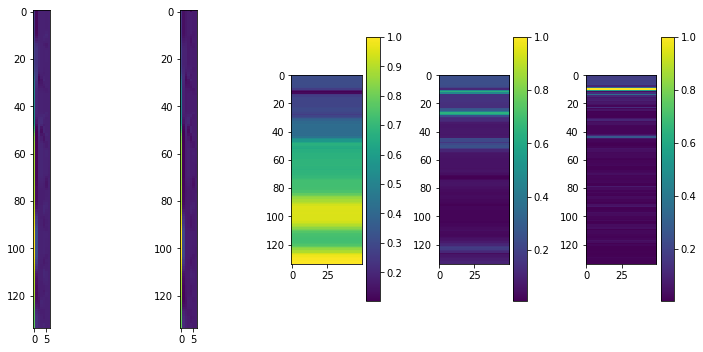

In [74]:
fig, ax = plt.subplots(1, 5)
plt.subplot(1, 5, 1)
# global_energy = np.abs(np.array(global_data))
# robot_energy = np.abs(np.array(robot_data))

global_energy = (np.array(W_opt))
robot_energy = (np.array(W_est))

plt.imshow(global_energy)
plt.subplot(1, 5, 2)
plt.imshow(robot_energy)

difference = np.linalg.norm(global_energy[:,0:2] - robot_energy[:,0:2], axis=1)
difference = np.reshape(difference, (-1,1))
difference = difference / np.max(difference)
plt.subplot(1, 5, 3)
diff_plot = plt.imshow(np.reshape(np.repeat(difference, 50, axis=0), (-1,50)))
plt.colorbar(diff_plot)

difference = np.linalg.norm(global_energy[:,2:5] - robot_energy[:,2:5], axis=1)
difference = np.reshape(difference, (-1,1))
difference = difference / np.max(difference)
plt.subplot(1, 5, 4)
diff_plot2 = plt.imshow(np.reshape(np.repeat(difference, 50, axis=0), (-1,50)))
plt.colorbar(diff_plot2)

difference = np.linalg.norm(global_energy[:,5:8] - robot_energy[:,5:8], axis=1)
difference = difference / np.max(difference)
difference = np.reshape(difference, (-1,1))
plt.subplot(1, 5, 5)
diff_plot3 = plt.imshow(np.reshape(np.repeat(difference, 50, axis=0), (-1,50)))
plt.colorbar(diff_plot3)
fig.tight_layout()

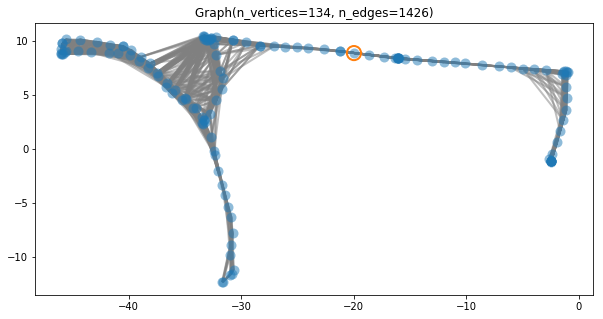

In [61]:
_ = global_graph_per_dataset[0].G.plot(highlight=[45])